In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from functions import (Calculate_CFD, create_position, plot_gaussian, get_gaussian_params,
                       calculate_gaussian_center, calculate_slope_y_intercept, continuous_delay)

In [3]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'

#non_normalized_data = np.load(os.path.join(dir,'pulsos_Na22_filt_norm_practica_polyfit_sin_normalizar.npz'))['data']
data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA.npz'))['data']
data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA.npz'))['data']
data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA.npz'))['data']

In [25]:
fraction = 0.064    # Fraction to attenuate pulse for CFD
shift = 6.8         # Delay for CFD 
threshold = 0.02  # Threshold for relative Leading Edge
t_shift = 1     
nbins = 71
time_step = 0.2   # In ns
positions = np.array([0.2, 0.0, -0.2])

# **CFD**

In [23]:
CTR = []
avg_bias = []
attenuation = np.array([0.01, 0.1, 0.2, 0.3])
delay = np.array([1, 2, 3, 4])

for i in range(attenuation.shape[0]):
    CTR_attenuation = []
    avg_bias_attenuation = []
    for j in range(delay.shape[0]):
        timestamps_CFD_dec0_DATA_00 = Calculate_CFD(data_55[:, :200, 0], fraction = attenuation[i], shift = delay[j], time_step = time_step)
        timestamps_CFD_dec1_DATA_00 = Calculate_CFD(data_55[:, :200, 1], fraction = attenuation[i], shift = delay[j], time_step = time_step)

        timestamps_CFD_dec0_DATA_02 = Calculate_CFD(data_28[:, :200, 0], fraction = attenuation[i], shift = delay[j], time_step = time_step)
        timestamps_CFD_dec1_DATA_02 = Calculate_CFD(data_28[:, :200, 1], fraction = attenuation[i], shift = delay[j], time_step = time_step)

        timestamps_CFD_dec0_DATA_20 = Calculate_CFD(data_82[:, :200, 0], fraction = attenuation[i], shift = delay[j], time_step = time_step)
        timestamps_CFD_dec1_DATA_20 = Calculate_CFD(data_82[:, :200, 1], fraction = attenuation[i], shift = delay[j], time_step = time_step)

        TOF_CFD_V00 = timestamps_CFD_dec0_DATA_00 - timestamps_CFD_dec1_DATA_00
        TOF_CFD_V02 = timestamps_CFD_dec0_DATA_02 - timestamps_CFD_dec1_DATA_02
        TOF_CFD_V20 = timestamps_CFD_dec0_DATA_20 - timestamps_CFD_dec1_DATA_20
        
        centroid_V00 = calculate_gaussian_center(TOF_CFD_V00[None,:], nbins = nbins, limits = 3) 

        params_V02, errors_V02 = get_gaussian_params(TOF_CFD_V02, centroid_V00, range = 0.8, nbins = nbins)
        params_V00, errors_V00 = get_gaussian_params(TOF_CFD_V00, centroid_V00, range = 0.8, nbins = nbins)
        params_V20, errors_V20 = get_gaussian_params(TOF_CFD_V20, centroid_V00, range = 0.8, nbins = nbins)

            
        resolution = np.mean((params_V20[3], params_V00[3], params_V02[3]))
        CTR_attenuation.append(resolution)

        centroids = np.array([params_V20[2], params_V00[2], params_V02[2]])
        bias = np.mean(abs(centroids - positions))
        avg_bias_attenuation.append(bias)
        print(resolution, bias)
        
    CTR.append(CTR_attenuation)
    avg_bias.append(avg_bias_attenuation)


0.45364580422615197 0.020377158091914246
0.38871975525921126 0.010939565423698184
0.3386052411086066 0.005252537243189098
0.31720360333029496 0.005091449453498293
0.32523274970926513 0.006612673125808002
0.2651547047606953 0.005952273881510404
0.25163065004211754 0.00589056057204865
0.2487406927794392 0.005368172477472183
0.2791376618073495 0.00731364861697053
0.28138138327575907 0.0056513187814838176
0.2814452116141095 0.0034871287773534914
0.280817366892004 0.0036609149736892364
0.28855061305742774 0.006485583117540929
0.32009357201797967 0.0038511682564588636
0.3361189382064642 0.0035520842828048725
0.33906528194488655 0.003169156995835761


(4, 4)


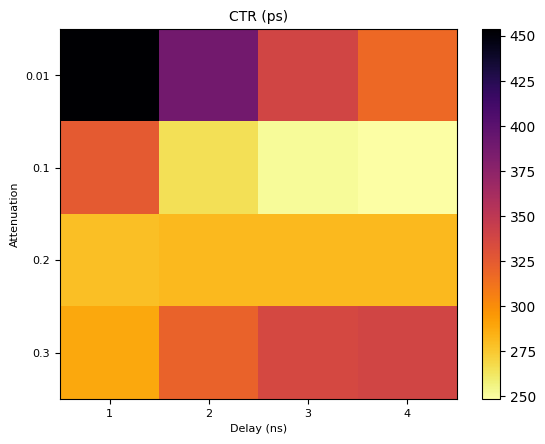

In [24]:
CTR = np.array(CTR, dtype = 'object')
print(CTR.shape)

plt.imshow(CTR.astype('float32')*1000, cmap = 'inferno_r', interpolation = 'nearest', aspect = 'auto');
plt.colorbar();
plt.title('CTR (ps)', fontsize = 10);
plt.ylabel('Attenuation', fontsize = 8);
plt.xlabel('Delay (ns)', fontsize = 8);
plt.yticks(np.arange(0, len(attenuation), 1).tolist(), attenuation.tolist(), fontsize = 8);  # X ticks at positions 3, 5, 7, 9
plt.xticks(np.arange(0, len(delay), 1).tolist(), delay.tolist(), fontsize = 8);  # Y ticks from 1 to 8


V20: CENTROID(ns) = 0.1895 +/- 0.00057  FWHM(ns) = 0.2358 +/- 0.00061
V00: CENTROID(ns) = -0.0004 +/- 0.00075  FWHM(ns) = 0.2354 +/- 0.00081
V02: CENTROID(ns) = -0.1947 +/- 0.00046  FWHM(ns) = 0.2378 +/- 0.00049


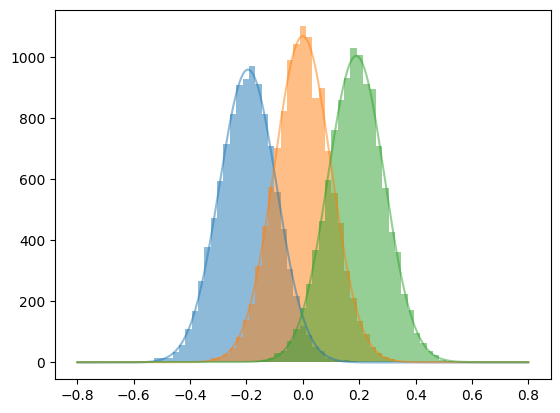

In [26]:
timestamps_CFD_dec0_DATA_00 = Calculate_CFD(data_55[:, :200, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_00 = Calculate_CFD(data_55[:, :200, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_02 = Calculate_CFD(data_28[:, :200, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_02 = Calculate_CFD(data_28[:, :200, 1], fraction = fraction, shift = shift, time_step = time_step)

timestamps_CFD_dec0_DATA_20 = Calculate_CFD(data_82[:, :200, 0], fraction = fraction, shift = shift, time_step = time_step)
timestamps_CFD_dec1_DATA_20 = Calculate_CFD(data_82[:, :200, 1], fraction = fraction, shift = shift, time_step = time_step)

TOF_CFD_V00 = timestamps_CFD_dec0_DATA_00 - timestamps_CFD_dec1_DATA_00
TOF_CFD_V02 = timestamps_CFD_dec0_DATA_02 - timestamps_CFD_dec1_DATA_02
TOF_CFD_V20 = timestamps_CFD_dec0_DATA_20 - timestamps_CFD_dec1_DATA_20

centroid_V00 = calculate_gaussian_center(TOF_CFD_V00[None,:], nbins = nbins, limits = 3) 
plot_gaussian(TOF_CFD_V02, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_CFD_V00, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_CFD_V20, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)

params_V02, errors_V02 = get_gaussian_params(TOF_CFD_V02, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_CFD_V00, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_CFD_V20, centroid_V00, range = 0.8, nbins = nbins)

print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))

In [27]:
# -------------------------------------------------------------------------
#--------------------------- BOOTSTRAPING ---------------------------------
# -------------------------------------------------------------------------

resolution_list = []
bias_list = []
MAE_list = []
for i in range(1000):
    a_00 = np.random.choice(np.arange(0, TOF_CFD_V00.shape[0]), size = TOF_CFD_V00.shape[0], replace = True)
    a_02 = np.random.choice(np.arange(0, TOF_CFD_V02.shape[0]), size = TOF_CFD_V02.shape[0], replace = True)
    a_20 = np.random.choice(np.arange(0, TOF_CFD_V20.shape[0]), size = TOF_CFD_V20.shape[0], replace = True)

    centroid_V00 = calculate_gaussian_center(TOF_CFD_V00[None, a_00], nbins = nbins, limits = 3) 
    params_V02, errors_V02 = get_gaussian_params(TOF_CFD_V02[a_02], centroid_V00, range = 0.8, nbins = nbins)
    params_V00, errors_V00 = get_gaussian_params(TOF_CFD_V00[a_00], centroid_V00, range = 0.8, nbins = nbins)
    params_V20, errors_V20 = get_gaussian_params(TOF_CFD_V20[a_20], centroid_V00, range = 0.8, nbins = nbins)
    
    
    resolution = np.mean((params_V20[3], params_V00[3], params_V02[3]))
    resolution_list.append(resolution)
    
    centroids = np.array([params_V20[2], params_V00[2], params_V02[2]])
    bias = np.mean(abs(centroids - positions))
    bias_list.append(bias)

    error_V02 = abs((TOF_CFD_V02 - centroid_V00[:, np.newaxis] + 0.2))
    error_V00 = abs((TOF_CFD_V00 - centroid_V00[:, np.newaxis] - 0.0))
    error_V20 = abs((TOF_CFD_V20 - centroid_V00[:, np.newaxis] - 0.2))

    Error = np.concatenate((error_V02, error_V00, error_V20), axis = 1)   
    MAE_list.append(np.mean(Error)) 

print('Mean CTR: ', np.mean(np.array(resolution_list))*1000)
print('Std CTR: ', np.std(np.array(resolution_list))*1000)
print('Mean bias: ', np.mean(np.array(bias_list))*1000)
print('Std bias: ', np.std(np.array(bias_list))*1000)
print('Mean MAE: ', np.mean(np.array(MAE_list))*1000)
print('Std MAE: ', np.std(np.array(MAE_list))*1000)



/home/josea/.local/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Mean CTR:  236.2326938507814
Std CTR:  1.4129867303456527
Mean bias:  5.427925999789371
Std bias:  0.5790425304114488
Mean MAE:  82.51733425701438
Std MAE:  0.020644753922580212


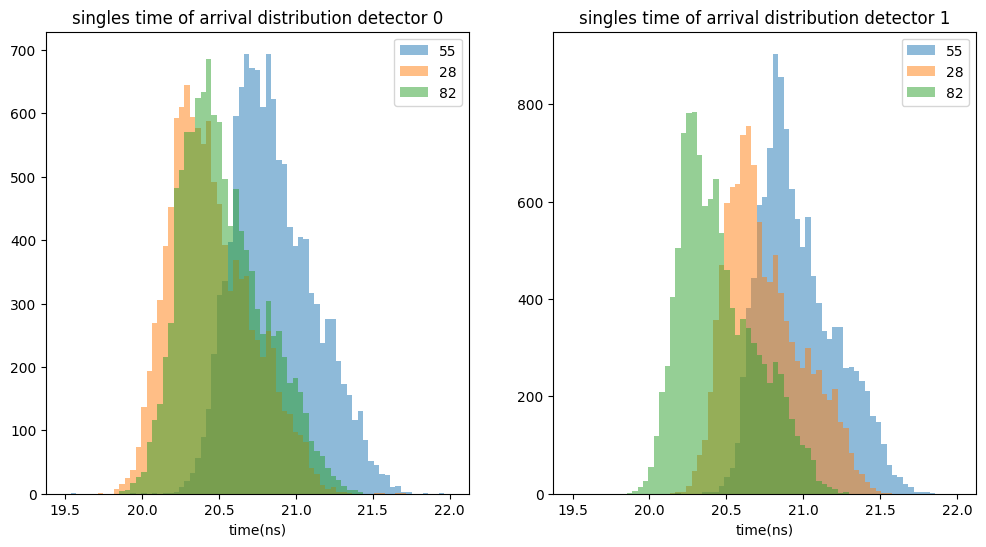

In [28]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.hist(timestamps_CFD_dec0_DATA_00, bins = nbins, range = [19.5, 22], alpha = 0.5, label = '55');
plt.hist(timestamps_CFD_dec0_DATA_02, bins = nbins, range = [19.5, 22], alpha = 0.5, label = '28');
plt.hist(timestamps_CFD_dec0_DATA_20, bins = nbins, range = [19.5, 22], alpha = 0.5, label = '82');
plt.title('singles time of arrival distribution detector 0')
plt.xlabel('time(ns)')
plt.legend()

plt.subplot(122)
plt.hist(timestamps_CFD_dec1_DATA_00, bins = nbins,  range = [19.5, 22], alpha = 0.5, label = '55');
plt.hist(timestamps_CFD_dec1_DATA_02, bins = nbins,  range = [19.5, 22], alpha = 0.5, label = '28');
plt.hist(timestamps_CFD_dec1_DATA_20, bins = nbins,  range = [19.5, 22], alpha = 0.5, label = '82');
plt.title('singles time of arrival distribution detector 1')
plt.xlabel('time(ns)')
plt.legend()

# **RELATIVE LEADING EDGE** 

In [29]:
timestamps_RLED_dec0_DATA_00_list = []
timestamps_RLED_dec0_DATA_02_list = []
timestamps_RLED_dec0_DATA_20_list = []

timestamps_RLED_dec1_DATA_00_list = []
timestamps_RLED_dec1_DATA_02_list = []
timestamps_RLED_dec1_DATA_20_list = []


for i in range(data_55.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_55[i,:,0], time_step, threshold = 2*threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_55[i,:,1], time_step, threshold = 2*threshold)
  timestamps_RLED_dec0_DATA_00_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_00_list.append(timestamp_dec1)

for i in range(data_28.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_28[i,:,0], time_step, threshold = 2*threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_28[i,:,1], time_step, threshold = 2*threshold)
  timestamps_RLED_dec0_DATA_02_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_02_list.append(timestamp_dec1)

for i in range(data_82.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_82[i,:,0], time_step, threshold = 2*threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_82[i,:,1], time_step, threshold = 2*threshold)
  timestamps_RLED_dec0_DATA_20_list.append(timestamp_dec0)
  timestamps_RLED_dec1_DATA_20_list.append(timestamp_dec1)


timestamps_RLED_dec0_DATA_00 = np.array(timestamps_RLED_dec0_DATA_00_list)
timestamps_RLED_dec0_DATA_02 = np.array(timestamps_RLED_dec0_DATA_02_list)
timestamps_RLED_dec0_DATA_20 = np.array(timestamps_RLED_dec0_DATA_20_list)

timestamps_RLED_dec1_DATA_00 = np.array(timestamps_RLED_dec1_DATA_00_list)
timestamps_RLED_dec1_DATA_02 = np.array(timestamps_RLED_dec1_DATA_02_list)
timestamps_RLED_dec1_DATA_20 = np.array(timestamps_RLED_dec1_DATA_20_list)

In [30]:
TOF_RLED_V00 = timestamps_RLED_dec0_DATA_00 - timestamps_RLED_dec1_DATA_00
TOF_RLED_V02 = timestamps_RLED_dec0_DATA_02 - timestamps_RLED_dec1_DATA_02
TOF_RLED_V20 = timestamps_RLED_dec0_DATA_20 - timestamps_RLED_dec1_DATA_20

V20: CENTROID(ns) = 0.1925 +/- 0.00050  FWHM(ns) = 0.2405 +/- 0.00054
V00: CENTROID(ns) = -0.0005 +/- 0.00054  FWHM(ns) = 0.2374 +/- 0.00058
V02: CENTROID(ns) = -0.1923 +/- 0.00061  FWHM(ns) = 0.2350 +/- 0.00066



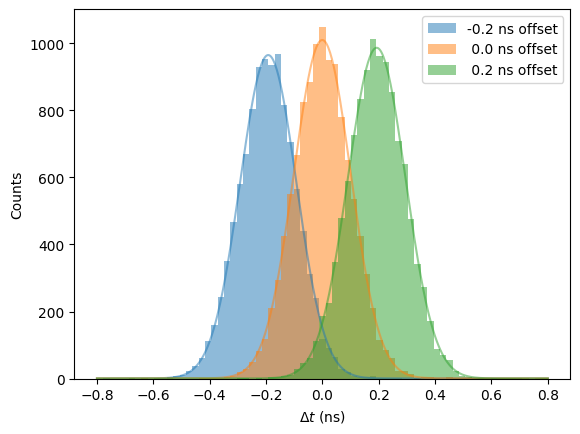

In [31]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
centroid_V00 = calculate_gaussian_center(TOF_RLED_V00[None,:], nbins = nbins, limits = 3) 

plot_gaussian(TOF_RLED_V02, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_RLED_V00, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_RLED_V20, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)

params_V02, errors_V02 = get_gaussian_params(TOF_RLED_V02, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_RLED_V00, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_RLED_V20, centroid_V00, range = 0.8, nbins = nbins)

print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')
plt.show()

In [32]:
# -------------------------------------------------------------------------
#--------------------------- BOOTSTRAPING ---------------------------------
# -------------------------------------------------------------------------

resolution_list = []
bias_list = []
MAE_list = []
for i in range(1000):
    a_00 = np.random.choice(np.arange(0, TOF_CFD_V00.shape[0]), size = TOF_CFD_V00.shape[0], replace = True)
    a_02 = np.random.choice(np.arange(0, TOF_CFD_V02.shape[0]), size = TOF_CFD_V02.shape[0], replace = True)
    a_20 = np.random.choice(np.arange(0, TOF_CFD_V20.shape[0]), size = TOF_CFD_V20.shape[0], replace = True)

    centroid_V00 = calculate_gaussian_center(TOF_CFD_V00[None, a_00], nbins = nbins, limits = 3) 
    params_V02, errors_V02 = get_gaussian_params(TOF_CFD_V02[a_02], centroid_V00, range = 0.8, nbins = nbins)
    params_V00, errors_V00 = get_gaussian_params(TOF_CFD_V00[a_00], centroid_V00, range = 0.8, nbins = nbins)
    params_V20, errors_V20 = get_gaussian_params(TOF_CFD_V20[a_20], centroid_V00, range = 0.8, nbins = nbins)
    
    
    resolution = np.mean((params_V20[3], params_V00[3], params_V02[3]))
    resolution_list.append(resolution)
    
    centroids = np.array([params_V20[2], params_V00[2], params_V02[2]])
    bias = np.mean(abs(centroids - positions))
    bias_list.append(bias)

    error_V02 = abs((TOF_CFD_V02 - centroid_V00[:, np.newaxis] + 0.2))
    error_V00 = abs((TOF_CFD_V00 - centroid_V00[:, np.newaxis] - 0.0))
    error_V20 = abs((TOF_CFD_V20 - centroid_V00[:, np.newaxis] - 0.2))

    Error = np.concatenate((error_V02, error_V00, error_V20), axis = 1)   
    MAE_list.append(np.mean(Error)) 

print('Mean CTR: ', np.mean(np.array(resolution_list))*1000)
print('Std CTR: ', np.std(np.array(resolution_list))*1000)
print('Mean bias: ', np.mean(np.array(bias_list))*1000)
print('Std bias: ', np.std(np.array(bias_list))*1000)
print('Mean MAE: ', np.mean(np.array(MAE_list))*1000)
print('Std MAE: ', np.std(np.array(MAE_list))*1000)


Mean CTR:  236.18375299195162
Std CTR:  1.5636061689868523
Mean bias:  5.45986442483138
Std bias:  0.5741490673453106
Mean MAE:  82.51703484334533
Std MAE:  0.019810411854963135


# **D-LED**

In [33]:
timestamps_DLED_dec0_DATA_00_list = []
timestamps_DLED_dec0_DATA_02_list = []
timestamps_DLED_dec0_DATA_20_list = []

timestamps_DLED_dec1_DATA_00_list = []
timestamps_DLED_dec1_DATA_02_list = []
timestamps_DLED_dec1_DATA_20_list = []


for i in range(data_55.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_55[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_55[i,:,1], time_step, threshold = threshold)
  timestamps_DLED_dec0_DATA_00_list.append(timestamp_dec0)
  timestamps_DLED_dec1_DATA_00_list.append(timestamp_dec1)

for i in range(data_28.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_28[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_28[i,:,1], time_step, threshold = threshold)
  timestamps_DLED_dec0_DATA_02_list.append(timestamp_dec0)
  timestamps_DLED_dec1_DATA_02_list.append(timestamp_dec1)

for i in range(data_82.shape[0]):
  timestamp_dec0 = calculate_slope_y_intercept(data_82[i,:,0], time_step, threshold = threshold)
  timestamp_dec1 = calculate_slope_y_intercept(data_82[i,:,1], time_step, threshold = threshold)
  timestamps_DLED_dec0_DATA_20_list.append(timestamp_dec0)
  timestamps_DLED_dec1_DATA_20_list.append(timestamp_dec1)


timestamps_DLED_dec0_DATA_00 = np.array(timestamps_DLED_dec0_DATA_00_list)
timestamps_DLED_dec0_DATA_02 = np.array(timestamps_DLED_dec0_DATA_02_list)
timestamps_DLED_dec0_DATA_20 = np.array(timestamps_DLED_dec0_DATA_20_list)

timestamps_DLED_dec1_DATA_00 = np.array(timestamps_DLED_dec1_DATA_00_list)
timestamps_DLED_dec1_DATA_02 = np.array(timestamps_DLED_dec1_DATA_02_list)
timestamps_DLED_dec1_DATA_20 = np.array(timestamps_DLED_dec1_DATA_20_list)

###
TOF_DLED_V00 = timestamps_DLED_dec0_DATA_00 - timestamps_DLED_dec1_DATA_00
TOF_DLED_V02 = timestamps_DLED_dec0_DATA_02 - timestamps_DLED_dec1_DATA_02
TOF_DLED_V20 = timestamps_DLED_dec0_DATA_20 - timestamps_DLED_dec1_DATA_20

V20: CENTROID(ns) = 0.1985 +/- 0.00079  FWHM(ns) = 0.2603 +/- 0.00086
V00: CENTROID(ns) = -0.0001 +/- 0.00080  FWHM(ns) = 0.2571 +/- 0.00088
V02: CENTROID(ns) = -0.1867 +/- 0.00071  FWHM(ns) = 0.2550 +/- 0.00078



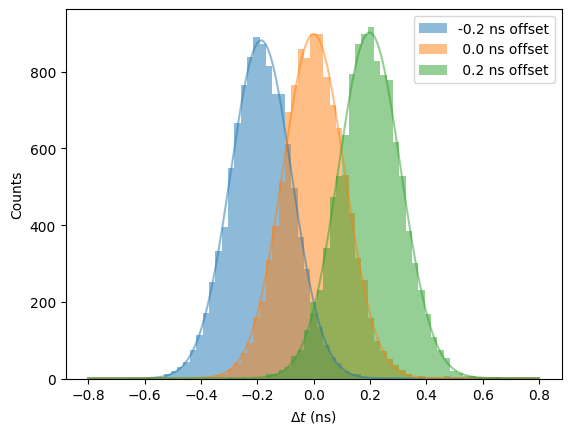

In [34]:
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
centroid_V00 = calculate_gaussian_center(TOF_DLED_V00[None,:], nbins = nbins, limits = 3) 

plot_gaussian(TOF_DLED_V02, centroid_V00, range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_DLED_V00, centroid_V00, range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_DLED_V20, centroid_V00, range = 0.8, label = ' 0.2 ns offset', nbins = nbins)

params_V02, errors_V02 = get_gaussian_params(TOF_DLED_V02, centroid_V00, range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_DLED_V00, centroid_V00, range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_DLED_V20, centroid_V00, range = 0.8, nbins = nbins)

print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')
plt.show()

In [35]:
# -------------------------------------------------------------------------
#--------------------------- BOOTSTRAPING ---------------------------------
# -------------------------------------------------------------------------

resolution_list = []
bias_list = []
MAE_list = []
for i in range(1000):
    a_00 = np.random.choice(np.arange(0, TOF_CFD_V00.shape[0]), size = TOF_CFD_V00.shape[0], replace = True)
    a_02 = np.random.choice(np.arange(0, TOF_CFD_V02.shape[0]), size = TOF_CFD_V02.shape[0], replace = True)
    a_20 = np.random.choice(np.arange(0, TOF_CFD_V20.shape[0]), size = TOF_CFD_V20.shape[0], replace = True)

    centroid_V00 = calculate_gaussian_center(TOF_CFD_V00[None, a_00], nbins = nbins, limits = 3) 
    params_V02, errors_V02 = get_gaussian_params(TOF_CFD_V02[a_02], centroid_V00, range = 0.8, nbins = nbins)
    params_V00, errors_V00 = get_gaussian_params(TOF_CFD_V00[a_00], centroid_V00, range = 0.8, nbins = nbins)
    params_V20, errors_V20 = get_gaussian_params(TOF_CFD_V20[a_20], centroid_V00, range = 0.8, nbins = nbins)
    
    
    resolution = np.mean((params_V20[3], params_V00[3], params_V02[3]))
    resolution_list.append(resolution)
    
    centroids = np.array([params_V20[2], params_V00[2], params_V02[2]])
    bias = np.mean(abs(centroids - positions))
    bias_list.append(bias)

    error_V02 = abs((TOF_CFD_V02 - centroid_V00[:, np.newaxis] + 0.2))
    error_V00 = abs((TOF_CFD_V00 - centroid_V00[:, np.newaxis] - 0.0))
    error_V20 = abs((TOF_CFD_V20 - centroid_V00[:, np.newaxis] - 0.2))

    Error = np.concatenate((error_V02, error_V00, error_V20), axis = 1)   
    MAE_list.append(np.mean(Error)) 

print('Mean CTR: ', np.mean(np.array(resolution_list))*1000)
print('Std CTR: ', np.std(np.array(resolution_list))*1000)
print('Mean bias: ', np.mean(np.array(bias_list))*1000)
print('Std bias: ', np.std(np.array(bias_list))*1000)
print('Mean MAE: ', np.mean(np.array(MAE_list))*1000)
print('Std MAE: ', np.std(np.array(MAE_list))*1000)

Mean CTR:  236.2472540660152
Std CTR:  1.5201952327481714
Mean bias:  5.471839676191326
Std bias:  0.5775265892591017
Mean MAE:  82.51751148064434
Std MAE:  0.021648368128650727


# **ML**

In [36]:
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/predictions'
test_dec0 = np.load(os.path.join(dir, 'test_dec0_Na22_KAN.npz'))['data']
test_dec1 = np.load(os.path.join(dir, 'test_dec1_Na22_KAN.npz'))['data']

In [37]:
# Calculate TOF
TOF = test_dec0 - test_dec1

size = int(test_dec0.shape[0]/5)
TOF_V02 = TOF[:size] 
TOF_V00 = TOF[size : 2*size] 
TOF_V20 = TOF[2*size :3*size] 
TOF_V04 = TOF[3*size :4*size] 
TOF_V40 = TOF[4*size:] 

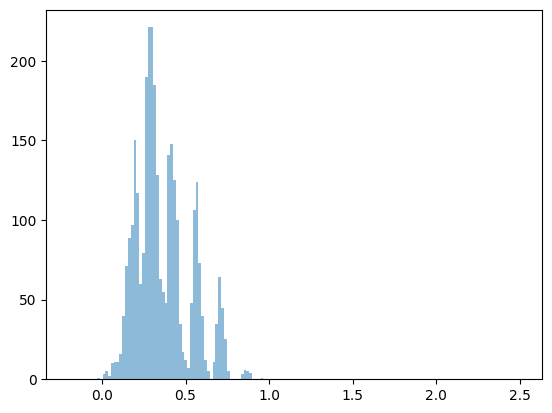

In [38]:
plt.hist(test_dec0[size : 2*size] , bins = nbins, alpha = 0.5, range = [-0.2, 1]);
plt.hist(timestamps_CFD_dec0_DATA_00 - 14, bins = nbins + 20, alpha = 0.5, range = [0,2.5]);  

In [39]:
from scipy.signal import find_peaks
# ML peaks
histogE, binsE = np.histogram(test_dec0[size : 2*size], bins = nbins, range = [-0.2,1]);
peaks = find_peaks(histogE, height = 50)[0]
pos_peaks = (binsE[peaks + 1] + binsE[peaks])/2
print(pos_peaks)

#CFD peaks
histogE, binsE = np.histogram(timestamps_CFD_dec0_DATA_00-14, bins = nbins, range = [0,2.5]);
peaks = find_peaks(histogE, height = 20)[0]
pos_peaks = (binsE[peaks + 1] + binsE[peaks])/2
print(pos_peaks)

[0.1971831  0.28169012 0.4169014  0.5690141  0.70422536]
[]
